# Projet linguistique

**Auteur** : Elsa Bidant

**Date** : Janvier 2025

## Introduction

Pour ce projet, j'ai souhaité m'intéresser au lien potentiel entre les thèmes abordés dans un poème et la fréquence des phonèmes qui le composent.
En m'appuyant sur *Les Fleurs du mal* de Charles Baudelaire, recueil où les thèmes du mal, de la mort et de l'amour occupent une place centrale, je cherche à déterminer si certains phonèmes se manifestent de manière récurrente en fonction du thème. 
Par exemple, je formule l’hypothèse que les sons en [r] apparaissent plus fréquemment dans les poèmes traitant du mal et de la mort, tandis que les sons liquides ([l]) prédomineraient dans les poèmes relatifs à l'amour à la mélancolie ou à la nature. 

**Problématique** : Dans quelle mesure la récurrence et la distribution des phonèmes dans *Les Fleurs du mal* de Charles Baudelaire reflètent-elles les thèmes centraux du recueil, et comment ces associations pourraient-elles éclairer le rôle de la sonorité dans l'expression poétique ?

In [32]:
# Bibliothèque informatiques
import requests
from bs4 import BeautifulSoup
import pandas as pd
import spacy
from collections import Counter

# Bibliothèques graphiques
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliothèques statistiques
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

Le code suivant a été entièrement généré par ChatGPT.

## 1. Scrapping

Commençons par récuperer le corpus sur internet. Ici j'ai choisi d'utiliser le texte de https://fr.wikisource.org. Le corpus de Baudelaire étant dans le domaine public, il n'y a pas de soucis pour l'utiliser ici.

In [33]:
# Fonction pour récupérer le texte de la page Wikisource
def get_wikisource_text(url):
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Erreur {response.status_code} lors de la récupération de la page.")
        return None
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Le texte principal est dans la div 'mw-parser-output'
    content_div = soup.find('div', class_ = 'mw-parser-output')
    
    # Retourner la partie contenant tous les poèmes et titres
    return content_div

# Fonction pour extraire les titres des poèmes et leur contenu
def extract_poems(content_div):
    # Trouver tous les titres des poèmes et leurs contenus
    poems = []
    current_poem_title = None
    current_poem_text = []
    
    # On parcourt tous les éléments dans la div principale
    for element in content_div.find_all(['h2', 'h3', 'p']):
        # Si l'élément est un titre de poème (h2 ou h3), on l'ajoute comme titre de poème
        if element.name == 'h2' or element.name == 'h3':
            if current_poem_title:  # Si un poème était en cours, on l'ajoute à la liste
                poems.append((current_poem_title, ' '.join(current_poem_text)))
            current_poem_title = element.get_text().strip()
            current_poem_text = []  # On commence un nouveau poème
        elif element.name == 'p':
            # On ajoute le texte du paragraphe au poème actuel
            current_poem_text.append(element.get_text().strip())

    # Ajouter le dernier poème récupéré
    if current_poem_title:
        poems.append((current_poem_title, ' '.join(current_poem_text)))

    return poems

# URL de la page Wikisource des Fleurs du mal (1861)
url = 'https://fr.wikisource.org/wiki/Les_Fleurs_du_mal_(1861)/Texte_entier'

# Récupérer le contenu de la page
content_div = get_wikisource_text(url)

# Extraire les poèmes et leurs titres
if content_div:
    poems = extract_poems(content_div)
    
    # Convertir en DataFrame pandas pour créer un dataset
    df = pd.DataFrame(poems, columns = ['Titre', 'Poème'])
    
    # Sauvegarder le DataFrame dans un fichier CSV
    df.to_csv('fleurs_du_mal.csv', index = False, encoding = 'utf-8')

In [34]:
df = pd.read_csv('fleurs_du_mal.csv') # Lire le CSV collecté

# Modifier le dataset
df = df.applymap(lambda x: x.replace("\n", " ") if isinstance(x, str) else x) # Enlever les balises HTLM
df = df.dropna() # Supprimer les lignes vides
df = df.drop(index = 133) # supprimer la ligne 133 qui est la table

C:\Users\elsab\AppData\Local\Temp\ipykernel_17568\1791745037.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace("\n", " ") if isinstance(x, str) else x) # Enlever les balises HTLM


In [35]:
# Afficher le dataset
pd.set_option('display.max_colwidth', None)
display(df)

,Titre,Poème
0,AU LECTEUR,"La sottise, l’erreur, le péché, la lésine, Occupent nos esprits et travaillent nos corps, Et nous alimentons nos aimables remords, Comme les mendiants nourrissent leur vermine. Nos péchés sont têtus, nos repentirs sont lâches ; Nous nous faisons payer grassement nos aveux, Et nous rentrons gaiement dans le chemin bourbeux, Croyant par de vils pleurs laver toutes nos taches. Sur l’oreiller du mal c’est Satan Trismégiste Qui berce longuement notre esprit enchanté, Et le riche métal de notre volonté Est tout vaporisé par ce savant chimiste. C’est le Diable qui tient les fils qui nous remuent ! Aux objets répugnants nous trouvons des appas ; Chaque jour vers l’Enfer nous descendons d’un pas, Sans horreur, à travers des ténèbres qui puent. Ainsi qu’un débauché pauvre qui baise et mange Le sein martyrisé d’une antique catin, Nous volons au passage un plaisir clandestin Que nous pressons bien fort comme une vieille orange. Serré, fourmillant, comme un million d’helminthes, Dans nos cerveaux ribote un peuple de Démons, Et, quand nous respirons, la Mort dans nos poumons Descend, fleuve invisible, avec de sourdes plaintes. Si le viol, le poison, le poignard, l’incendie, N’ont pas encor brodé de leurs plaisants dessins Le canevas banal de nos piteux destins, C’est que notre âme, hélas ! n’est pas assez hardie. Mais parmi les chacals, les panthères, les lices, Les singes, les scorpions, les vautours, les serpents, Les monstres glapissants, hurlants, grognants, rampants, Dans la ménagerie infâme de nos vices, Il en est un plus laid, plus méchant, plus immonde ! Quoiqu’il ne pousse ni grands gestes ni grands cris, Il ferait volontiers de la terre un débris Et dans un bâillement avalerait le monde ; C’est l’Ennui ! — l’œil chargé d’un pleur involontaire, Il rêve d’échafauds en fumant son houka. Tu le connais, lecteur, ce monstre délicat, — Hypocrite lecteur, — mon semblable, — mon frère !"
2,IBÉNÉDICTION,"Lorsque, par un décret des puissances supremes, Le Poëte apparaît en ce monde ennuyé, Sa mère épouvantée et pleine de blasphèmes Crispe ses poings vers Dieu, qui la prend en pitié : — « Ah ! que n’ai-je mis bas tout un nœud de vipères, Plutôt que de nourrir cette dérision ! Maudite soit la nuit aux plaisirs éphémères Où mon ventre a conçu mon expiation ! Puisque tu m’as choisie entre toutes les femmes Pour être le dégoût de mon triste mari, Et que je ne puis pas rejeter dans les flammes, Comme un billet d’amour, ce monstre rabougri, Je ferai rejaillir ta haine qui m’accable Sur l’instrument maudit de tes méchancetés, Et je tordrai si bien cet arbre misérable, Qu’il ne pourra pousser ses boutons empestés ! » Elle ravale ainsi l’écume de sa haine, Et, ne comprenant pas les desseins éternels, Elle-même prépare au fond de la Géhenne Les bûchers consacrés aux crimes maternels. Pourtant, sous la tutelle invisible d’un Ange, L’Enfant déshérité s’enivre de soleil, Et dans tout ce qu’il boit et dans tout ce qu’il mange Retrouve l’ambroisie et le nectar vermeil. Il joue avec le vent, cause avec le nuage, Et s’enivre en chantant du chemin de la croix ; Et l’Esprit qui le suit dans son pèlerinage Pleure de le voir gai comme un oiseau des bois. Tous ceux qu’il veut aimer l’observent avec crainte, Ou bien, s’enhardissant de sa tranquillité, Cherchent à qui saura lui tirer une plainte, Et font sur lui l’essai de leur férocité. Dans le pain et le vin destinés à sa bouche Ils mêlent de la cendre avec d’impurs crachats ; Avec hypocrisie ils jettent ce qu’il touche, Et s’accusent d’avoir mis leurs pieds dans ses pas. Sa femme va criant sur les places publiques : « Puisqu’il me trouve assez belle pour m’adorer, Je ferai le métier des idoles antiques, Et comme elles je veux me faire redorer ; Et je me soûlerai de nard, d’encens, de myrrhe, De génuflexions, de viandes et de vins, Pour savoir si je puis dans un cœur qui m’admire Usurper en riant les hommages divins ! Et, quand je m’ennuierai de ces farces impies, Je poserai sur lui ma f

## 2. Compter les phonèmes avec Lexique

In [36]:
# Charger le modèle Spacy pour le français
nlp = spacy.load('fr_core_news_md')

lexique = pd.read_csv('Lexique383.tsv', sep = '\t', encoding = 'utf-8')  # Charger la base Lexique

# Préparer un dictionnaire {mot: phonème} à partir de Lexique
lexique_dict = dict(zip(lexique['ortho'], lexique['phon']))

# Fonction pour analyser le texte et compter les phonèmes
def compter_phonemes(texte):
    doc = nlp(texte)
    phoneme_counter = Counter()
    
    for token in doc:
        mot = token.text.lower()
        phonemes = lexique_dict.get(mot)  # Récupérer les phonèmes du mot
        if phonemes:
            for phoneme in phonemes:  # Chaque caractère est un phonème
                phoneme_counter[phoneme] += 1
                
    return phoneme_counter

# Appliquer la fonction à la colonne 'poeme'
df['phoneme_counts'] = df['Poème'].apply(lambda x: compter_phonemes(x))

# Décomposer les comptes en colonnes distinctes pour chaque phonème
phoneme_columns = set(phoneme for counts in df['phoneme_counts'] for phoneme in counts.keys())
for phoneme in phoneme_columns:
    df[phoneme] = df['phoneme_counts'].apply(lambda x: x.get(phoneme, 0))

# Supprimer la colonne temporaire 'phoneme_counts'
df.drop(columns = ['phoneme_counts'], inplace = True)

# Transformer les phonèmes en colonnes individuelles dans la base Lexique
lexique['phonemes_split'] = lexique['phon'].apply(list)
phoneme_split_columns = pd.DataFrame(lexique['phonemes_split'].tolist(), index=lexique.index)
lexique = pd.concat([lexique, phoneme_split_columns], axis = 1)

# Sauvegarder le dataset avec les phonèmes comptés
df.to_csv('dataset_avec_phonemes.csv', index = False, encoding = 'utf-8')
df = pd.read_csv('dataset_avec_phonemes.csv')

## 3. Regrouper les phonèmes selon leur type

Les phonèmes et leur codage Lexique sont regroupés ici http://www.lexique.org/?page_id=286. 

Le but ici est de rassembler les phonèmes selon leur type et l'effet potentiel qu'ils apportent en poésie.

In [37]:
# Montrer toutes les colonnes, et donc tous les phonèmes trouvés
print(df.columns)

Index(['Titre', 'Poème', 'd', 'w', 'p', 'Z', '1', '8', 'x', 'i', 'n', 'g', 'a',
       'l', 's', 'k', '5', '@', '§', 'N', 'y', 'E', 'm', 'u', '9', 'R', '2',
       't', 'S', 'b', 'z', '°', 'o', 'O', 'f', 'v', 'j', 'e'],
      dtype='object')


In [38]:
# Création d'un dictionnaire des phonèmes et leurs types
PHONEMES_CATEGORIES = {
    'e' : 'voyelle fermée', 'k' : 'occlusive', 'm' : 'nasale', 'w' : 'semi-voyelle', 'y' : 'voyelle', 'v' : 'fricative', 
    '§' : 'voyelle', 'O' : 'voyelle ouverte', 'l' : 'liquide', 'z' : 'sifflante', '°' : 'voyelle', 'N' : 'nasale', 
    '1' : 'voyelle nasale', 'u' :'voyelle', 'p' :'occlusive', 'Z' : 'fricative', '@' :'voyelle nasale', 's' : 'sifflante', 
    'f' : 'fricative', 'g' : 'occlusive', 'd' : 'occlusive', 'i' : 'voyelle', '5' : 'voyelle nasale', 'S' : 'sifflante', 
    'j' : 'semi-voyelle', '2' : 'voyelle fermée', '9' : 'voyelle ouverte', 'n' : 'nasale', 'o' : 'voyelle fermée', 
    '8' : 'semi-voyelle', 'E' : 'voyelle ouverte', 'a' : 'voyelle', 'x' : 'fricative', 'b' : 'occlusive', 'R' : 'liquide', 't' : 'occlusive'
}

# Regrouper les phonèmes par catégorie et les additioner
def regrouper_par_type(df):
    phoneme_type_columns = {
        'voyelle': 0,
        'voyelle fermée': 0,
        'voyelle ouverte': 0,
        'voyelle nasale': 0,
        'semi-voyelle': 0,
        'fricative': 0,
        'liquide': 0,
        'sifflante': 0,
        'occlusive': 0,
        'nasale': 0,
    }
    
    # Pour chaque ligne du DataFrame, on va additionner les phonèmes par type
    for index, row in df.iterrows():
        # Initialiser un compteur pour chaque type
        type_counts = {key: 0 for key in phoneme_type_columns}
        
        # Pour chaque phonème dans le DataFrame, on l'associe à son type et on ajoute sa fréquence
        for phoneme, count in row.items():
            if isinstance(count, int):  # Vérifier que le "count" est bien un entier
                if phoneme in PHONEMES_CATEGORIES:
                    phoneme_type = PHONEMES_CATEGORIES[phoneme]
                    type_counts[phoneme_type] += count

        # Ajouter les comptes par type de phonème à la ligne du DataFrame
        for phoneme_type, count in type_counts.items():
            df.at[index, phoneme_type] = count
    
    return df

# Appliquer le regroupement des phonèmes par type
df = regrouper_par_type(df)

## 4. Trouver les thèmes des poèmes

Il est difficile de trouver avec fiabilité le thème principal traité par un poème. J'ai donc décidé de regrouper les poèmes sous plusieurs grands thèmes : la beauté et l'esthétique, la condition de poète, le spleen et la mélancolie, le mal et le péché, le passage du temps et la fuite du temps, le double et la contradiction, la recherche de liberté, l’isolement, la ville et la modernité, le paradis artificiel, le corps et le désir, la nature et l'art, le cosmisme et l'ésotérisme, l'amour et la souffrance, la révolte et la rédemption et enfin la mort.

Pour cela j'ai pris les poèmes un à un et leur ai attribué des thèmes à la main.

In [39]:
# Chargement du dataset contenant les thèmes des poèmes
df2 = pd.read_csv('fleurs_du_mal_thèmes.csv', encoding='latin1', delimiter=';')
pd.set_option('display.max_colwidth', 20)
display(df2)

,Titre,Poème,La beauté et l'esthétique,La condition de poète,Le spleen et la mélancolie,Le mal et le péché,Le passage du temps et la fuite du temps,Le double et la contradiction,La recherche de liberté,L'isolement,La ville et la modernité,Le paradis artificiel,Le corps et le désir,La nature et l'art,Le cosmisme et l'ésotérisme,L'amour et la souffrance,La révolte et la rédemption,La mort
0,AU LECTEUR,"La sottise, ler...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,IBÉNÉDICTION,"Lorsque, par un ...",0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,IILALBATROS,"Souvent, pour s...",0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,IIIÉLÉVATION,Au-dessus des ét...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,IVCORRESPONDANCES,La Nature est un...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,CXXIILA MORT DES...,Cest la Mort qu...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
123,CXXIIILA MORT DE...,Combien faut-il ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
124,CXXIVLA FIN DE L...,Sous une lumière...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
125,CXXVLE RÊVE DUN...,"Connais-tu, comm...",0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1


## 5. Rassembler les thèmes et les phonèmes

In [40]:
# Concaténation horizontale (ajout de colonnes) des deux datasets (phonèmes et thèmes)
df2_unique = df2.loc[:, ~df2.columns.isin(df.columns)]
df_combined = pd.concat([df, df2_unique], axis=1)

# Afficher le résultat
display(df_combined)

,Titre,Poème,d,w,p,Z,1,8,x,i,...,La recherche de liberté,L'isolement,La ville et la modernité,Le paradis artificiel,Le corps et le désir,La nature et l'art,Le cosmisme et l'ésotérisme,L'amour et la souffrance,La révolte et la rédemption,La mort
0,AU LECTEUR,"La sottise, l’er...",34,3,42,10,9,1,0,54,...,0,0,0,0,0,0,0,0,0,0
1,IBÉNÉDICTION,"Lorsque, par un ...",83,16,74,29,10,15,0,104,...,0,0,0,0,0,0,0,0,0,0
2,IIL’ALBATROS,"Souvent, pour s’...",14,6,11,4,2,4,0,19,...,0,0,0,0,0,0,0,0,0,0
3,IIIÉLÉVATION,Au-dessus des ét...,27,7,18,5,2,5,0,28,...,0,0,0,0,0,0,1,0,0,0
4,IVCORRESPONDANCES,La Nature est un...,17,4,15,1,3,1,0,17,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,CXXIILA MORT DES...,C’est la Mort qu...,12,6,7,6,2,0,0,24,...,1,0,0,0,0,0,0,0,0,1
123,CXXIIILA MORT DE...,Combien faut-il ...,15,6,12,3,3,0,0,14,...,0,0,0,0,0,0,0,0,1,1
124,CXXIVLA FIN DE L...,Sous une lumière...,10,0,6,2,0,2,0,10,...,0,0,0,0,0,0,1,0,0,1
125,CXXVLE RÊVE D’UN...,"Connais-tu, comm...",14,7,9,0,2,0,0,15,...,0,0,0,0,0,0,1,0,0,1


## 6. Représentations monovariées

C:\Users\elsab\AppData\Local\Temp\ipykernel_17568\3924551176.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = phoneme_counts, x = 'Phonème', y = 'Occurrences', palette = 'viridis')


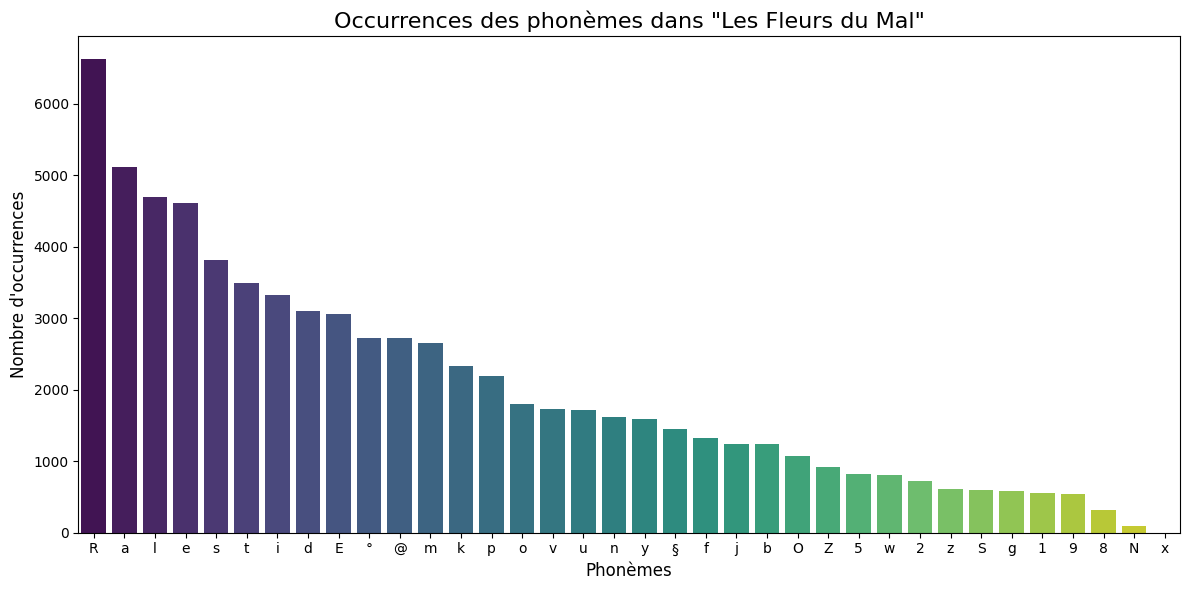

In [41]:
# Colonnes contenant les phonèmes
phoneme_columns = ['v', '@', 'f', '1', 'o', 'y', '°', 'N', 'l', 'S', 'E', 'Z', 'x',
                   'b', 's', 'u', 'g', 'i', 'O', '9', 'p', 'z', 'e', '5', 't', 'a', 
                   'n', 'w', 'm', '2', '8', 'k', 'j', '§', 'R', 'd']

# Calculer la somme totale pour chaque phonème
phoneme_counts = df_combined[phoneme_columns].sum().reset_index()
phoneme_counts.columns = ['Phonème', 'Occurrences']

# Trier les phonèmes par nombre d'occurrences décroissant
phoneme_counts = phoneme_counts.sort_values(by = 'Occurrences', ascending = False)

# Créer un barplot avec seaborn
plt.figure(figsize = (12, 6))
sns.barplot(data = phoneme_counts, x = 'Phonème', y = 'Occurrences', palette = 'viridis')

# Ajouter des titres et des labels
plt.title('Occurrences des phonèmes dans "Les Fleurs du Mal"', fontsize = 16)
plt.xlabel('Phonèmes', fontsize = 12)
plt.ylabel('Nombre d\'occurrences', fontsize = 12)

# Afficher le graphique
plt.tight_layout()
plt.show()

C:\Users\elsab\AppData\Local\Temp\ipykernel_17568\3702415996.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = type_phoneme_counts, x = 'Type de phonème', y = 'Occurrences', palette = 'viridis')


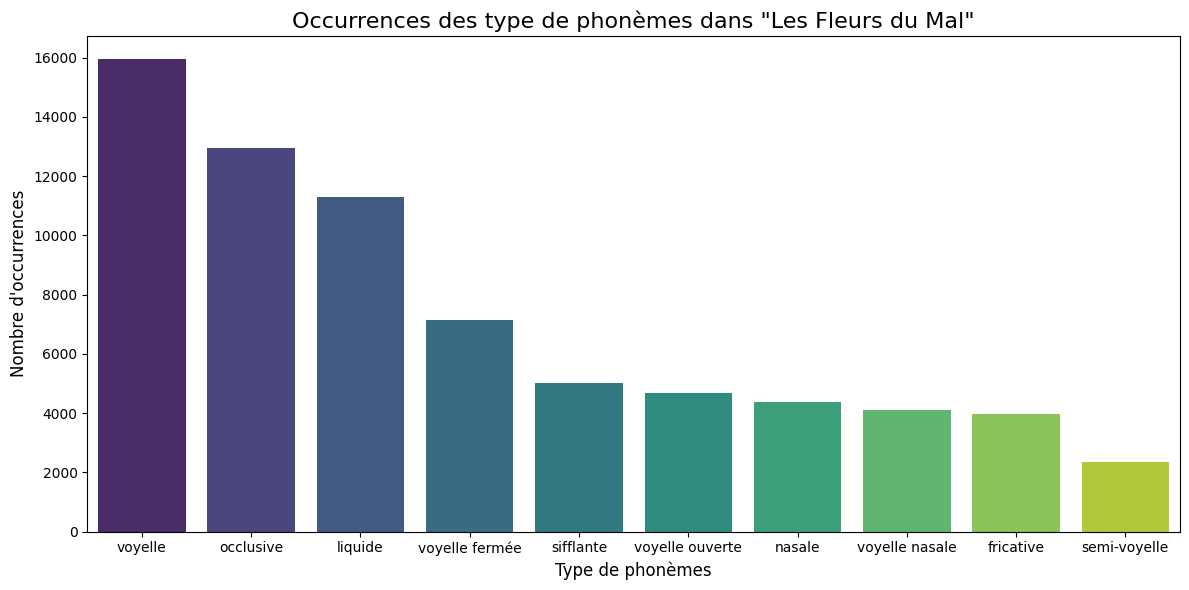

In [42]:
# Colonnes contenant les type de phonèmes
type_phoneme_columns = ['voyelle', 'voyelle fermée', 'voyelle ouverte', 'voyelle nasale', 'semi-voyelle',
        'fricative', 'liquide', 'sifflante', 'occlusive', 'nasale']

# Calculer la somme totale pour chaque type de phonème
type_phoneme_counts = df_combined[type_phoneme_columns].sum().reset_index()
type_phoneme_counts.columns = ['Type de phonème', 'Occurrences']

# Trier les type de phonèmes par nombre d'occurrences décroissant
type_phoneme_counts = type_phoneme_counts.sort_values(by = 'Occurrences', ascending = False)

# Créer un barplot avec seaborn
plt.figure(figsize = (12, 6))
sns.barplot(data = type_phoneme_counts, x = 'Type de phonème', y = 'Occurrences', palette = 'viridis')

# Ajouter des titres et des labels
plt.title('Occurrences des type de phonèmes dans "Les Fleurs du Mal"', fontsize = 16)
plt.xlabel('Type de phonèmes', fontsize = 12)
plt.ylabel('Nombre d\'occurrences', fontsize = 12)

# Afficher le graphique
plt.tight_layout()
plt.show()

C:\Users\elsab\AppData\Local\Temp\ipykernel_17568\711110934.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = theme_counts, x = 'Occurrences', y = 'Thème', palette = 'mako')


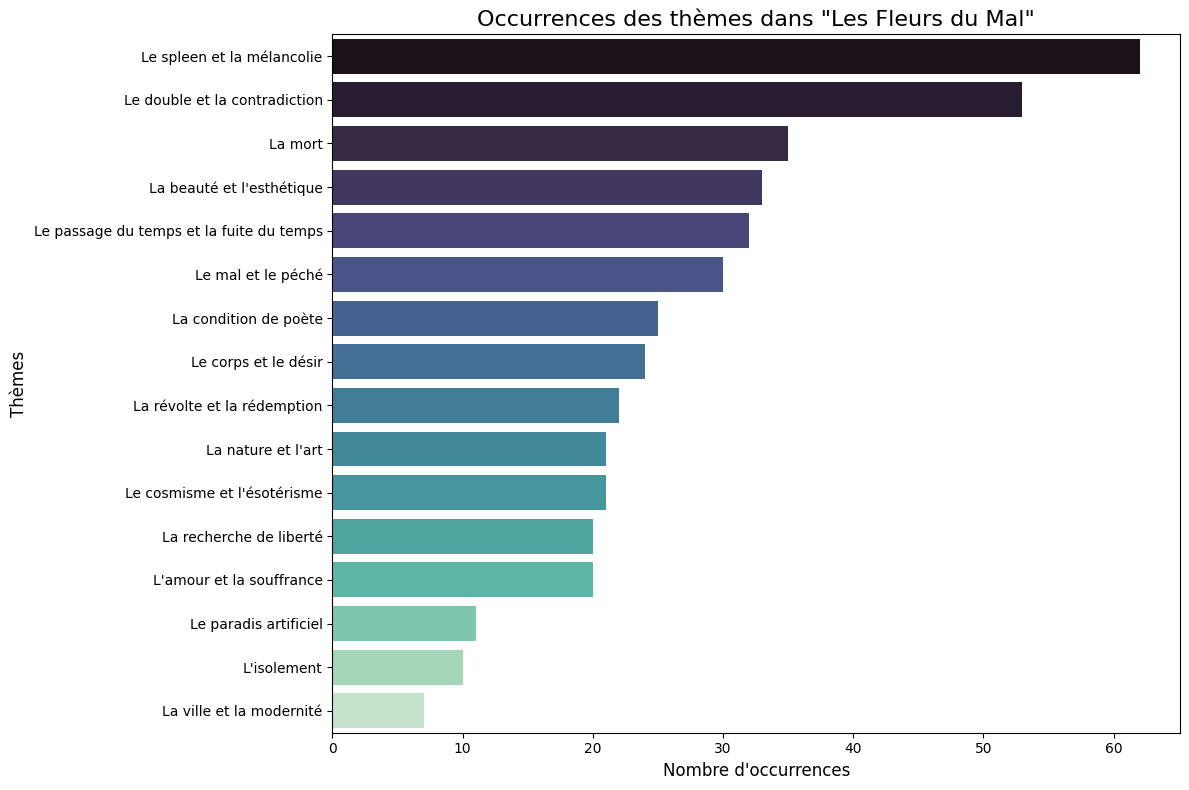

In [43]:
# Colonnes contenant les thèmes
theme_columns = [
    "La beauté et l'esthétique", "Le spleen et la mélancolie", "La condition de poète",
    "Le mal et le péché", "Le passage du temps et la fuite du temps", 
    "Le double et la contradiction", "La recherche de liberté", 
    "L'isolement", "La ville et la modernité", "Le paradis artificiel", 
    "Le corps et le désir", "La nature et l'art", "Le cosmisme et l'ésotérisme", 
    "L'amour et la souffrance", "La révolte et la rédemption", "La mort"
]

# Calculer la somme totale pour chaque thème
theme_counts = df_combined[theme_columns].sum().reset_index()
theme_counts.columns = ['Thème', 'Occurrences']

# Trier les thèmes par nombre d'occurrences décroissant
theme_counts = theme_counts.sort_values(by = 'Occurrences', ascending = False)

# Créer un barplot avec seaborn
plt.figure(figsize = (12, 8))
sns.barplot(data = theme_counts, x = 'Occurrences', y = 'Thème', palette = 'mako')

# Ajouter des titres et des labels
plt.title('Occurrences des thèmes dans "Les Fleurs du Mal"', fontsize = 16)
plt.xlabel('Nombre d\'occurrences', fontsize = 12)
plt.ylabel('Thèmes', fontsize = 12)

# Afficher le graphique
plt.tight_layout()
plt.show()

## 7. Représentations bivariées

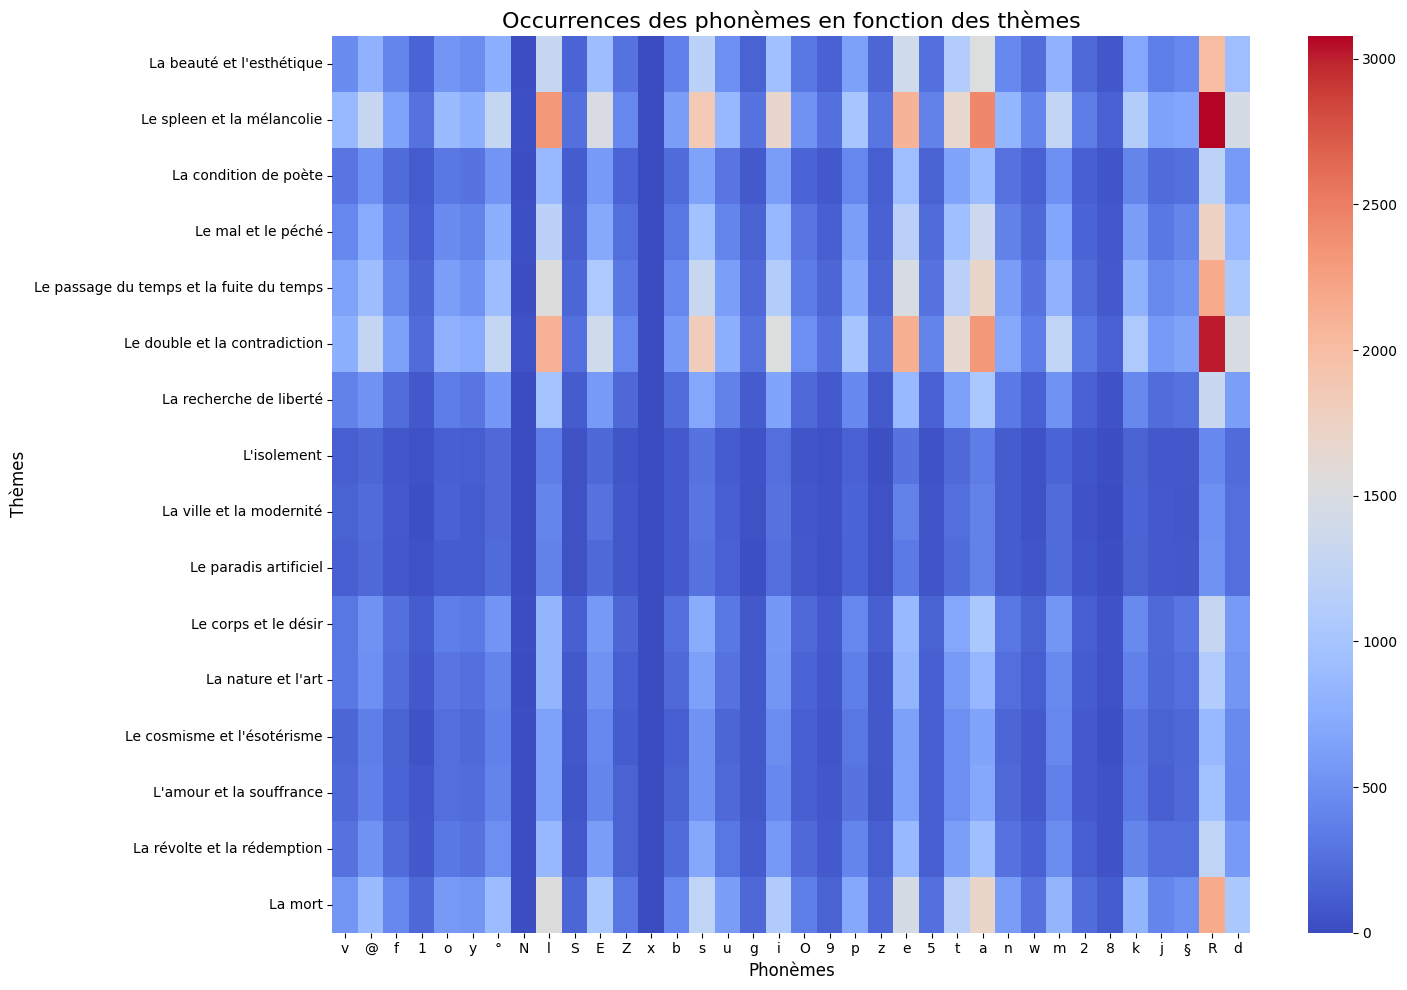

In [44]:
# Calculer les occurrences totales des phonèmes pour chaque thème
theme_phoneme_counts = df_combined[theme_columns].T.dot(df_combined[phoneme_columns])

# Transformer en DataFrame pour faciliter l'analyse
theme_phoneme_counts = theme_phoneme_counts.reset_index()
theme_phoneme_counts.columns = ['Thème'] + phoneme_columns

# Visualisation des données avec une heatmap
plt.figure(figsize = (15, 10))
sns.heatmap(theme_phoneme_counts.set_index('Thème'), annot = False, cmap = 'coolwarm', cbar = True)

# Ajouter des labels
plt.title('Occurrences des phonèmes en fonction des thèmes', fontsize = 16)
plt.xlabel('Phonèmes', fontsize = 12)
plt.ylabel('Thèmes', fontsize = 12)

# Afficher le graphique
plt.tight_layout()
plt.show()

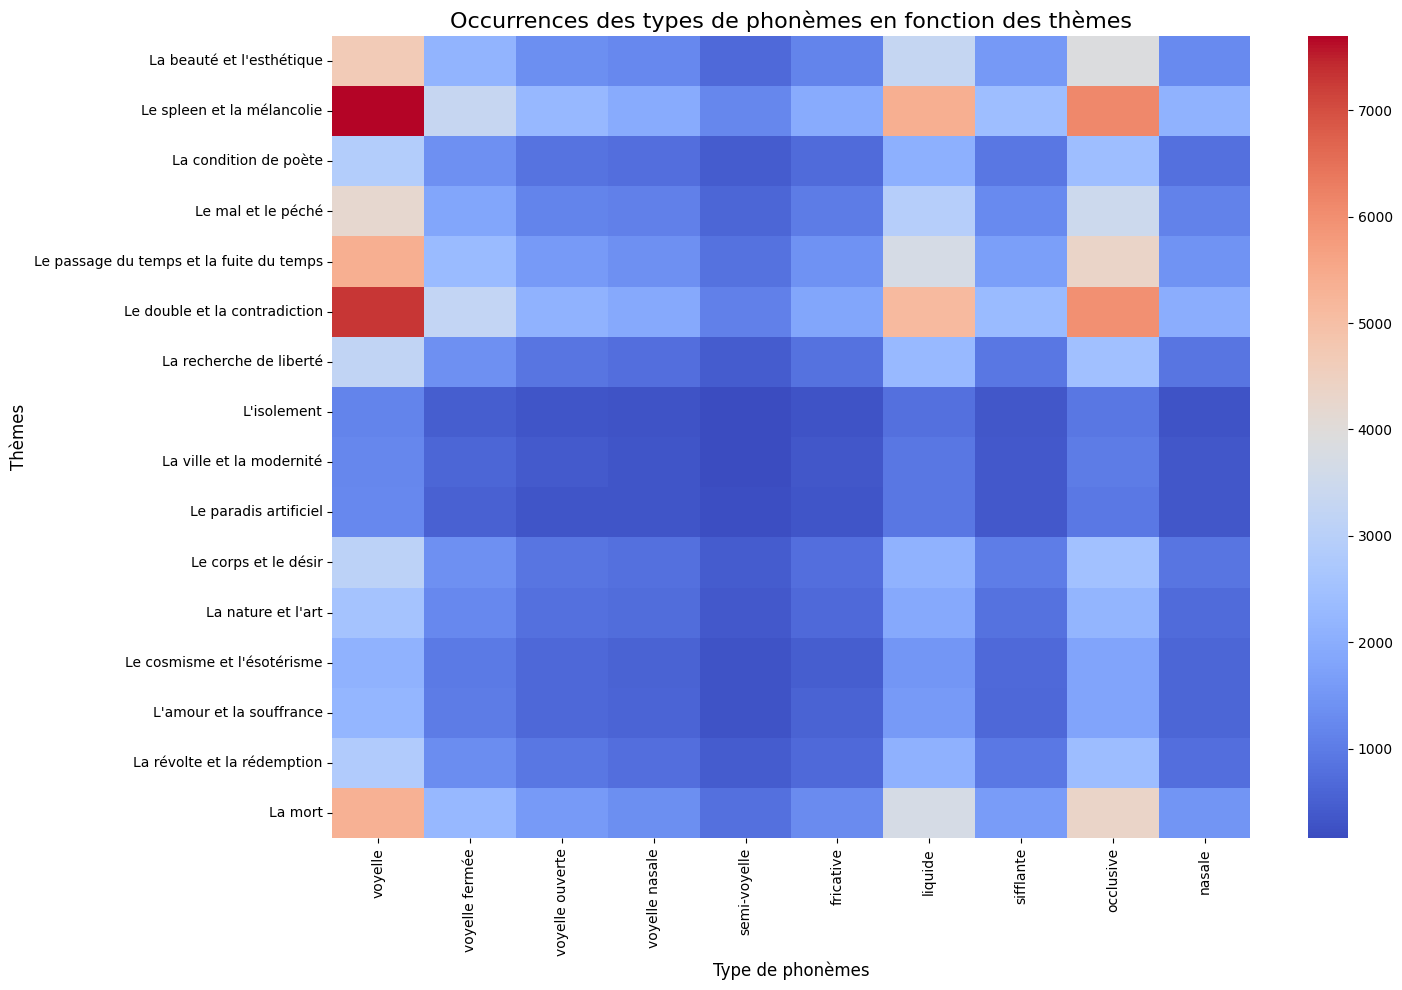

In [45]:
# Calculer les occurrences totales des phonèmes pour chaque thème
theme_type_phoneme_counts = df_combined[theme_columns].T.dot(df_combined[type_phoneme_columns])

# Transformer en DataFrame pour faciliter l'analyse
theme_type_phoneme_counts = theme_type_phoneme_counts.reset_index()
theme_type_phoneme_counts.columns = ['Thème'] + type_phoneme_columns

# Visualiser les données avec une heatmap
plt.figure(figsize = (15, 10))
sns.heatmap(theme_type_phoneme_counts.set_index('Thème'), annot = False, cmap = 'coolwarm', cbar = True)

# Ajouter des labels
plt.title('Occurrences des types de phonèmes en fonction des thèmes', fontsize = 16)
plt.xlabel('Type de phonèmes', fontsize = 12)
plt.ylabel('Thèmes', fontsize = 12)

# Afficher le graphique
plt.tight_layout()
plt.show()

## 8. Tests statistiques sur l'ensemble du recueil

J'ai ici efféctué deux tests du Chi-2 pour tester s'il existe, ou non, un lien significatif entre les phonèmes (ou types de phonèmes) et les thèmes des poèmes.

#### 1. Test avec les phonèmes

In [46]:
# Liste pour stocker les résultats
results = []

# Pour chaque thème, effectuer un test du Khi-Deux
for theme in theme_columns:
    try:
        # Créer un tableau de contingence pour le thème et les phonèmes
        contingency_table = df_combined.groupby(theme)[phoneme_columns].sum()

        # Effectuer le test du Khi-Deux
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Ajouter les résultats dans la liste
        results.append({
            'Thème': theme,
            'Chi2': chi2,
            'p-value': p,
            'Degrees of Freedom': dof,
            'Significatif': 'Oui' if p < 0.05 else 'Non'
        })
    except KeyError as e:
        print(f"Erreur avec la colonne : {theme}. Détail : {e}")

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Afficher les résultats sous forme de tableau côte à côte
display(results_df.style.set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]))


,Thème,Chi2,p-value,Degrees of Freedom,Significatif
0,La beauté et l'esthétique,48.751719,0.061201,35,Non
1,Le spleen et la mélancolie,77.527373,0.000047,35,Oui
2,La condition de poète,49.306294,0.055044,35,Non
3,Le mal et le péché,63.310410,0.002356,35,Oui
4,Le passage du temps et la fuite du temps,72.480522,0.000201,35,Oui
5,Le double et la contradiction,41.662953,0.203438,35,Non
6,La recherche de liberté,60.335380,0.004927,35,Oui
7,L'isolement,54.199128,0.020195,35,Oui
8,La ville et la modernité,65.589857,0.001311,35,Oui
9,Le paradis artificiel,45.011850,0.119694,35,Non


#### 2. Test avec les types de phonèmes

In [47]:
# Liste pour stocker les résultats
results = []

# Pour chaque thème, effectuer un test du Khi-Deux
for theme in theme_columns:
    try:
        # Créer un tableau de contingence pour le thème et les phonèmes
        contingency_table = df_combined.groupby(theme)[type_phoneme_columns].sum()

        # Effectuer le test du Khi-Deux
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Ajouter les résultats dans la liste
        results.append({
            'Thème': theme,
            'Chi2': chi2,
            'p-value': p,
            'Degrees of Freedom': dof,
            'Significatif': 'Oui' if p < 0.05 else 'Non'
        })
    except KeyError as e:
        print(f"Erreur avec la colonne : {theme}. Détail : {e}")

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Afficher les résultats sous forme de tableau côte à côte
display(results_df.style.set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]))

,Thème,Chi2,p-value,Degrees of Freedom,Significatif
0,La beauté et l'esthétique,10.618370,0.302777,9,Non
1,Le spleen et la mélancolie,19.483098,0.021385,9,Oui
2,La condition de poète,10.515151,0.310411,9,Non
3,Le mal et le péché,17.893714,0.036427,9,Oui
4,Le passage du temps et la fuite du temps,20.360757,0.015812,9,Oui
5,Le double et la contradiction,4.955760,0.838148,9,Non
6,La recherche de liberté,23.697105,0.004807,9,Oui
7,L'isolement,3.115165,0.959553,9,Non
8,La ville et la modernité,16.885606,0.050538,9,Non
9,Le paradis artificiel,10.638163,0.301328,9,Non


Nous allons maitenant nous intéresser plus en profondeur aux deux thèmes suivants : le mal et le péché et le spleen et la mélancolie. En effet, ces thèmes sont significativement associés aux phonèmes et types de phonèmes qui les composent.

## 9. Analyse de "Le mal et le péché"

J'ai choisi de réaliser une regression logistique pour savoir si les phonèmes sont individuellement et significativement associés ou non au thème Le mal et le péché.

In [64]:
# Construction de la formule pour le modèle
formula = f"Q('Le mal et le péché') ~ " + " + ".join([f"Q('{col}')" for col in phoneme_columns])

# Ajustement du modèle
model = smf.logit(formula = formula, data = df_combined).fit()

# Résumé du modèle
model.summary()

         Current function value: 0.336471
         Iterations: 35


C:\Users\elsab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                             
===================================================================================
Dep. Variable:     Q('Le mal et le péché')   No. Observations:                  127
Model:                               Logit   Df Residuals:                       90
Method:                                MLE   Df Model:                           36
Date:                     Sat, 11 Jan 2025   Pseudo R-squ.:                  0.3845
Time:                             20:55:43   Log-Likelihood:                -42.732
converged:                           False   LL-Null:                       -69.429
Covariance Type:                 nonrobust   LLR p-value:                   0.03104
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3346      0.836     -3.989      0.000      -4.973      -1.696
Q('v')        -0.0432      0.090     -0.480      0.631      -0.220       0.133
Q('@')         0.1903      0.108      1.764      0.078      -0.021       0.402
Q('f')        -0.0199      0.133     -0.149      0.882      -0.281       0.242
Q('1')         0.0942      0.155      0.607      0.544      -0.210       0.398
Q('o')         0.0286      0.091      0.315      0.753      -0.150       0.207
Q('y')     -4.515e-05      0.085     -0.001      1.000      -0.166       0.166
Q('°')         0.2492      0.104      2.389      0.017       0.045       0.454
Q('N')         1.0857      0.414      2.620      0.009       0.273       1.898
Q('l')        -0.0091      0.073     -0.124      0.902      -0.153       0.135
Q('S')        -0.4647      0.209     -2.226      0.026      -0.874      -0.056
Q('E')        -0.1874      0.107     -1.754      0.079      -0.397       0.022
Q('Z')        -0.0375      0.147     -0.255      0.799      -0.326       0.251
Q('x')        21.0837   1.39e+04      0.002      0.999   -2.72e+04    2.73e+04
Q('b')        -0.0310      0.120     -0.258      0.796      -0.267       0.204
Q('s')        -0.0588      0.078     -0.755      0.450      -0.211       0.094
Q('u')        -0.1191      0.098     -1.210      0.226      -0.312       0.074
Q('g')        -0.0270      0.197     -0.137      0.891      -0.412       0.359
Q('i')         0.0469      0.094      0.499      0.618      -0.137       0.231
Q('O')         0.2128      0.130      1.636      0.102      -0.042       0.468
Q('9')        -0.0534      0.183     -0.292      0.771      -0.412       0.306
Q('p')        -0.0725      0.096     -0.753      0.451      -0.261       0.116
Q('z')         0.1375      0.175      0.786      0.432      -0.206       0.481
Q('e')         0.0279      0.062      0.452      0.652      -0.093       0.149
Q('5')         0.1410      0.122      1.155      0.248      -0.098       0.380
Q('t')         0.0080      0.078      0.103      0.918      -0.144       0.160
Q('a')         0.0221      0.077      0.285      0.775      -0.130       0.174
Q('n')        -0.0900      0.083     -1.082      0.279      -0.253       0.073
Q('w')        -0.1505      0.151     -0.998      0.318      -0.446       0.145
Q('m')        -0.0611      0.089     -0.686      0.492      -0.235       0.113
Q('2')        -0.0247      0.143     -0.173      0.863      -0.305       0.255
Q('8')         0.2144      0.209      1.024      0.306      -0.196       0.625
Q('k')        -0.1807      0.099     -1.833      0.067      -0.374       0.013
Q('j')        -0.1647      0.109     -1.512      0.131      -0.378       0.049
Q('§')         0.0593      0.144      0.412      0.680      -0.223       0.341
Q('R')         0.0633      0.065      0.981      0.327      -0.063       0.190
Q('d')         0.0286      0.081      0.352      0.725      -0.131       0.188
====================================

In [65]:
# Extraire les coefficients et leurs p-valeurs
summary_table = model.summary2().tables[1]  # Table des coefficients
significance_threshold = 0.05  # Seuil de significativité

# Identifier les variables significatives
significant_vars = summary_table[summary_table['P>|z|'] < significance_threshold]

# Afficher les varaibles significatives
print("\nVariables significatives :")
if not significant_vars.empty:
    print(significant_vars[['Coef.', 'P>|z|']])
else:
    print("Aucune variable significative trouvée.")


Variables significatives :
              Coef.     P>|z|
Intercept -3.334605  0.000066
Q('°')     0.249228  0.016912
Q('N')     1.085666  0.008802
Q('S')    -0.464658  0.025989


On peut ici conclure que les phonèmes 'gn' (N), 'ch' (S), et le schwa élidable (°) sont sigificativement associé au le thème Le mal et le péché. Le schwa élidable et le 'gn' lui sont associés positivement (coefficients positifs de *0.25* et *1.09*) alors que le 'ch' semble avoir un effet négatif (coefficient négatif *-0.46*).

Je réalise une autre regression logistique pour savoir si les phonèmes sont individuellement et significativement associés ou non au thème Le mal et le péché.

In [66]:
# Construction de la formule pour le modèle
formula = f"Q('Le mal et le péché') ~ " + " + ".join([f"Q('{col}')" for col in type_phoneme_columns])

# Ajustement du modèle
model = smf.logit(formula = formula, data = df_combined).fit()

# Résumé du modèle
model.summary()

Optimization terminated successfully.
         Current function value: 0.497156
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                             
===================================================================================
Dep. Variable:     Q('Le mal et le péché')   No. Observations:                  127
Model:                               Logit   Df Residuals:                      116
Method:                                MLE   Df Model:                           10
Date:                     Sat, 11 Jan 2025   Pseudo R-squ.:                 0.09060
Time:                             20:55:43   Log-Likelihood:                -63.139
converged:                            True   LL-Null:                       -69.429
Covariance Type:                 nonrobust   LLR p-value:                    0.2481
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.5053      0.383     -3.930      0.000      -2.256      -0.755
Q('voyelle')             0.0221      0.036      0.613      0.540      -0.049       0.093
Q('voyelle fermée')     -0.0104      0.034     -0.310      0.757      -0.076       0.056
Q('voyelle ouverte')    -0.0572      0.047     -1.207      0.227      -0.150       0.036
Q('voyelle nasale')      0.0396      0.046      0.853      0.393      -0.051       0.131
Q('semi-voyelle')       -0.0034      0.048     -0.070      0.944      -0.098       0.091
Q('fricative')          -0.0380      0.048     -0.795      0.427      -0.132       0.056
Q('liquide')             0.0168      0.030      0.561      0.575      -0.042       0.076
Q('sifflante')          -0.0530      0.042     -1.264      0.206      -0.135       0.029
Q('occlusive')           0.0142      0.030      0.478      0.632      -0.044       0.072
Q('nasale')             -0.0222      0.046     -0.483      0.629      -0.112       0.068
========================================================================================
"""

In [67]:
# Extraire les coefficients et leurs p-valeurs
summary_table = model.summary2().tables[1]  # Table des coefficients
significance_threshold = 0.05  # Seuil de significativité

# Identifier les variables significatives
significant_vars = summary_table[summary_table['P>|z|'] < significance_threshold]

# Afficher les varaibles significatives
print("\nVariables significatives :")
if not significant_vars.empty:
    print(significant_vars[['Coef.', 'P>|z|']])
else:
    print("Aucune variable significative trouvée.")


Variables significatives :
              Coef.     P>|z|
Intercept -1.505297  0.000085


On remarque qu'aucun type de phonèmes n'est significativement associé au thème Le mal et le péché.

## 10. Analyse de "Le spleen et la mélancolie"

J'ai choisi de réaliser une regression logistique pour savoir si les phonèmes sont individuellement et significativement associés ou non au thème Le spleen et la mélancolie.

In [68]:
# Construction de la formule pour le modèle
formula = f"Q('Le spleen et la mélancolie') ~ " + " + ".join([f"Q('{col}')" for col in phoneme_columns])

# Ajustement du modèle
model = smf.logit(formula = formula, data = df_combined).fit()

# Résumé du modèle
model.summary()

         Current function value: 0.433704
         Iterations: 35


C:\Users\elsab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Logit Regression Results                                 
===========================================================================================
Dep. Variable:     Q('Le spleen et la mélancolie')   No. Observations:                  127
Model:                                       Logit   Df Residuals:                       90
Method:                                        MLE   Df Model:                           36
Date:                             Sat, 11 Jan 2025   Pseudo R-squ.:                  0.3740
Time:                                     20:56:52   Log-Likelihood:                -55.080
converged:                                   False   LL-Null:                       -87.994
Covariance Type:                         nonrobust   LLR p-value:                  0.001747
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6834      0.679      1.007      0.314      -0.647       2.014
Q('v')        -0.0085      0.093     -0.091      0.927      -0.190       0.173
Q('@')        -0.0826      0.088     -0.938      0.348      -0.255       0.090
Q('f')         0.0936      0.114      0.818      0.413      -0.131       0.318
Q('1')         0.0281      0.129      0.218      0.828      -0.225       0.282
Q('o')        -0.0003      0.078     -0.004      0.996      -0.153       0.152
Q('y')         0.0312      0.077      0.402      0.687      -0.121       0.183
Q('°')        -0.0591      0.080     -0.742      0.458      -0.215       0.097
Q('N')        -0.2665      0.335     -0.794      0.427      -0.924       0.391
Q('l')         0.1290      0.064      2.000      0.045       0.003       0.255
Q('S')        -0.2251      0.152     -1.482      0.138      -0.523       0.073
Q('E')        -0.0010      0.066     -0.016      0.987      -0.130       0.128
Q('Z')        -0.0563      0.124     -0.455      0.649      -0.299       0.186
Q('x')       -19.3635   1.38e+04     -0.001      0.999   -2.71e+04    2.71e+04
Q('b')         0.0842      0.101      0.834      0.404      -0.114       0.282
Q('s')         0.0323      0.068      0.472      0.637      -0.102       0.167
Q('u')         0.0496      0.086      0.580      0.562      -0.118       0.217
Q('g')        -0.0629      0.159     -0.395      0.693      -0.375       0.249
Q('i')         0.0623      0.080      0.775      0.438      -0.095       0.220
Q('O')        -0.0661      0.101     -0.652      0.514      -0.265       0.133
Q('9')         0.1447      0.154      0.939      0.348      -0.157       0.447
Q('p')        -0.1070      0.083     -1.284      0.199      -0.270       0.056
Q('z')         0.1776      0.133      1.336      0.181      -0.083       0.438
Q('e')        -0.1486      0.059     -2.514      0.012      -0.264      -0.033
Q('5')        -0.0584      0.111     -0.526      0.599      -0.276       0.159
Q('t')         0.0310      0.068      0.458      0.647      -0.102       0.164
Q('a')        -0.0954      0.069     -1.373      0.170      -0.232       0.041
Q('n')         0.2155      0.093      2.319      0.020       0.033       0.398
Q('w')         0.3474      0.130      2.678      0.007       0.093       0.602
Q('m')         0.0456      0.074      0.615      0.539      -0.100       0.191
Q('2')         0.1330      0.131      1.019      0.308      -0.123       0.389
Q('8')        -0.1259      0.191     -0.659      0.510      -0.500       0.248
Q('k')         0.0053      0.073      0.072      0.943      -0.138       0.148
Q('j')         0.3099      0.100      3.113      0.002       0.115       0.505
Q('§')        -0.0580      0.107     -0.541      0.588      -0.268       0.152
Q('R')        -0.0897      0.053     -1.701      0.089      -0.193       0.014
Q('d')        -0.0151      0.072     -0.211

In [69]:
# Extraire les coefficients et leurs p-valeurs
summary_table = model.summary2().tables[1]  # Table des coefficients
significance_threshold = 0.05  # Seuil de significativité

# Identifier les variables significatives
significant_vars = summary_table[summary_table['P>|z|'] < significance_threshold]

# Afficher les varaibles significatives
print("\nVariables significatives :")
if not significant_vars.empty:
    print(significant_vars[['Coef.', 'P>|z|']])
else:
    print("Aucune variable significative trouvée.")


Variables significatives :
           Coef.     P>|z|
Q('l')  0.128966  0.045472
Q('e') -0.148614  0.011932
Q('n')  0.215505  0.020392
Q('w')  0.347422  0.007400
Q('j')  0.309905  0.001855


Les phonèmes 'l' (l), 'n' (n), 'y' (j), 'w' (w) et 'é' (e) sont significativement associé au thème Le spleen et la mélancolie.
Les phonèmes 'l' (l), 'n' (n), 'w' (w) et 'y' (j) ont un impact positif sur le thème "Le spleen et la mélancolie" (coefficients positifs de respectivement *0.13* , *0.22*, *0.35* et *0.31*). À l’inverse, le phonème 'é' (e) a un impact négatif sur ce thème (coefficient de *-0.15*).

Maintenant je réalise une autre regression logistique pour savoir si les types de phonèmes sont individuellement et significativement associés ou non au thème Le spleen et la mélancolie.

In [70]:
# Construction de la formule pour le modèle
formula = f"Q('Le spleen et la mélancolie') ~ " + " + ".join([f"Q('{col}')" for col in type_phoneme_columns])

# Ajustement du modèle
model = smf.logit(formula = formula, data = df_combined).fit()

# Résumé du modèle
model.summary()

Optimization terminated successfully.
         Current function value: 0.630244
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Logit Regression Results                                 
===========================================================================================
Dep. Variable:     Q('Le spleen et la mélancolie')   No. Observations:                  127
Model:                                       Logit   Df Residuals:                      116
Method:                                        MLE   Df Model:                           10
Date:                             Sat, 11 Jan 2025   Pseudo R-squ.:                 0.09038
Time:                                     20:56:52   Log-Likelihood:                -80.041
converged:                                    True   LL-Null:                       -87.994
Covariance Type:                         nonrobust   LLR p-value:                    0.1023
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1545      0.340      0.454      0.649      -0.512       0.821
Q('voyelle')            -0.0178      0.030     -0.587      0.558      -0.077       0.042
Q('voyelle fermée')     -0.0502      0.029     -1.720      0.085      -0.107       0.007
Q('voyelle ouverte')     0.0219      0.038      0.571      0.568      -0.053       0.097
Q('voyelle nasale')     -0.0290      0.038     -0.758      0.449      -0.104       0.046
Q('semi-voyelle')        0.1368      0.048      2.830      0.005       0.042       0.232
Q('fricative')           0.0325      0.039      0.845      0.398      -0.043       0.108
Q('liquide')             0.0009      0.026      0.035      0.972      -0.050       0.051
Q('sifflante')           0.0026      0.035      0.074      0.941      -0.065       0.070
Q('occlusive')          -0.0055      0.025     -0.218      0.827      -0.055       0.044
Q('nasale')              0.0522      0.041      1.268      0.205      -0.028       0.133
========================================================================================
"""

In [71]:
# Extraire les coefficients et leurs p-valeurs
summary_table = model.summary2().tables[1]  # Table des coefficients
significance_threshold = 0.05  # Seuil de significativité

# Identifier les variables significatives
significant_vars = summary_table[summary_table['P>|z|'] < significance_threshold]

# Afficher les varaibles significatives
print("\nVariables significatives :")
if not significant_vars.empty:
    print(significant_vars[['Coef.', 'P>|z|']])
else:
    print("Aucune variable significative trouvée.")


Variables significatives :
                      Coef.    P>|z|
Q('semi-voyelle')  0.136794  0.00466


On remarque que seules les semi-voyelles sont significativement associées au thème Le spleen et la mélancolie, et qu'elles ont un impact positif (coefficient de *0.14*).

## 11. Conclusion

Cette étude a permis d'explorer le lien entre les thèmes poétiques et les phonèmes dans *Les Fleurs du mal* de Charles Baudelaire. Une analyse globale à l’aide du test du Chi2 a révélé que certains thèmes sont significativement associés à des phonèmes ou types de phonèmes spécifiques. Par exemple, les thèmes "Le mal et le péché" et "Le spleen et la mélancolie".

Une analyse plus approfondie de ces deux thèmes, grâce à deux regressions logistiques, montre qu'il y a bien des phonèmes qui sont significativement associés à ces thèmes.

Pour le thème "Le mal et le péché", les phonèmes 'gn' (N), 'ch' (S) et le schwa élidable (°) se démarquent. Contrairement à ma prédiction initiale, le phonème 'r' ne semble pas jouer un rôle significatif ici. Toutefois, les phonèmes identifiés offrent des avantages stylistiques clairs : le schwa élidable évoque une ellipse sonore, traduisant une perte ou un effacement, tandis que le 'gn' véhicule une tension ou une oppression, renforçant ainsi l’atmosphère sombre et conflictuelle du péché et du mal. En revanche, la moindre présence de 'ch' suggère une réduction de la friction sonore et de l'agressivité directe.

Dans le thème "Le spleen et la mélancolie", les phonèmes 'l' (l), 'n' (n), 'y' (j), 'w' (w) et 'é' (e), ainsi que les semi-voyelles, se distinguent significativement. Le 'l', en tant que phonème liquide, est indissociable de la douceur et de la langueur mélancolique (comme prédit). Le 'n', par sa résonance nasale, traduit une introspection et une intériorité propre au spleen. Les semi-voyelles, telles que 'y' et 'w', traduisent l’éphémère et la fuite. À l’inverse, la faible présence de 'é' reflète un repli et une absence de lumière, renforçant les tonalités sombres du spleen.

Ces résultats montrent que la récurrence et la distribution des phonèmes contribuent à l'expression poétique et au renforcement des thèmes centraux du recueil. En effet, les sons ne sont pas seulement des éléments stylistiques ; ils participent à la construction des ambiances et des émotions propres à chaque thème. Cette association confirme que, dans la poésie de Baudelaire, il existe bien un lien significatif entre le thème et la sonorité (ce résultat ne semble cependant pas généralisable à tous les poèmes).

Cependant, il convient de souligner certaines limites. Cette analyse repose sur un seul recueil et une catégorisation subjective des thèmes, ce qui peut influencer les résultats. Étendre cette étude à d’autres recueils, poètes, époques ou cultures pourrait permettre d’explorer si ces relations entre thèmes et phonèmes sont généralisables. Une telle approche offrirait une perspective plus large sur le rôle de la sonorité dans l'expression poétique à travers les époques et les traditions littéraires.

En conclusion, cette étude démontre que les phonèmes jouent un rôle fondamental dans l’expression des thèmes poétiques, confirmant ainsi leur importance dans l’analyse linguistique et stylistique de la poésie.